In [3]:
#imports
from control import lqr
from scipy import integrate, signal
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot(t, v_i, a_i, d, d_ref, e):
    fig = plt.figure(figsize=(12,7))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    ax1.plot(t, d, label='Gap')
    ax1.plot(t, d_ref, label='Gap Reference')
    ax1.plot(t, e, label='Error')
    ax1.set_xlabel('Time (s)')
    ax1.set_title('Gap/Error Dynamics')
    ax1.legend()
    ax1.grid()

    ax2.plot(t, v_i*3.6, 'b', label = 'Ego car speed')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Velocity (km/h)')
    ax2.set_title('Input response')
    ax2.grid()
    ax2.legend()
    ax2.tick_params(axis='y', labelcolor='b')
    ax3 = ax2.twinx()
    ax3.plot(t, a_i, 'r', label = 'Actuation: Ego car acc')
    ax3.set_ylabel('Acceleration (m/s^2')
    ax3.tick_params(axis='y', labelcolor='r')
    ax3.legend()


# Constant Spacing Policy

## PID

[-1.00000000e+00 -8.41971276e-01 -7.00374873e-01 -5.73606801e-01
 -4.60198569e-01 -3.58808418e-01 -2.68203312e-01 -1.87310119e-01
 -1.15224309e-01 -5.10987795e-02  5.85884071e-03  5.63861880e-02
  1.01166166e-01  1.40818647e-01  1.75834696e-01  2.06633216e-01
  2.33610806e-01  2.57142180e-01  2.77580165e-01  2.95255702e-01
  3.10477845e-01  3.23526128e-01  3.34604412e-01  3.43883255e-01
  3.51526553e-01  3.57691510e-01  3.62528640e-01  3.66181766e-01
  3.68788020e-01  3.70477842e-01  3.71369274e-01  3.71530695e-01
  3.71024364e-01  3.69912758e-01  3.68256058e-01  3.66112151e-01
  3.63536631e-01  3.60582796e-01  3.57301653e-01  3.53741933e-01
  3.49949999e-01  3.45948712e-01  3.41752230e-01  3.37375499e-01
  3.32834250e-01  3.28145001e-01  3.23325056e-01  3.18392503e-01
  3.13366218e-01  3.08265864e-01  3.03111887e-01  2.97925521e-01
  2.92728786e-01  2.87539812e-01  2.82354714e-01  2.77170537e-01
  2.71985813e-01  2.66799906e-01  2.61613006e-01  2.56426135e-01
  2.51241142e-01  2.46060

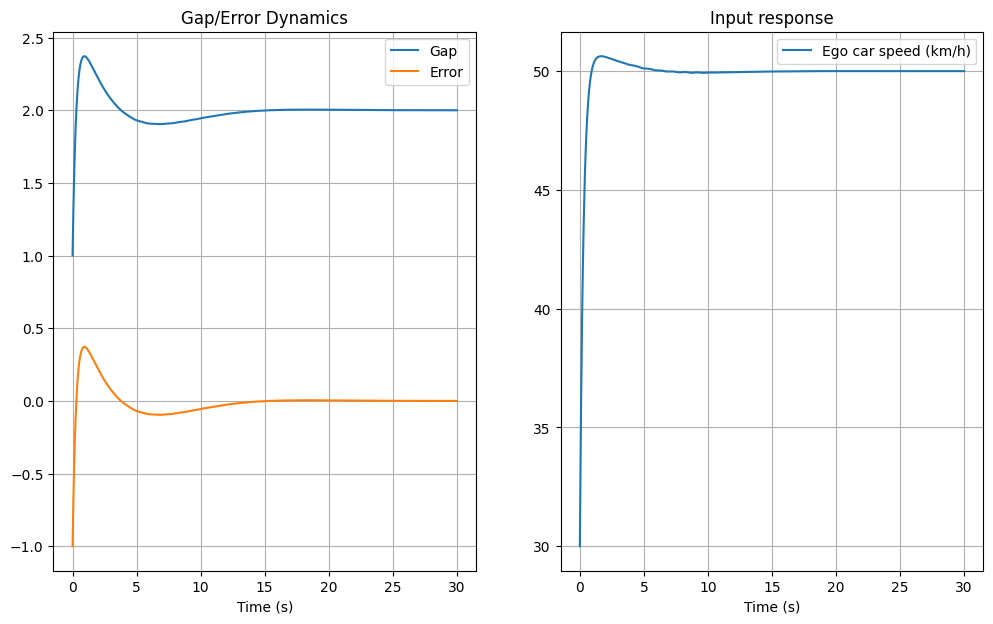

In [19]:
d_ref = 2 # gap target (m)

#PI constants
Kp = 2
Ki = 0.5
Kd = 4

def System(t: float, x: np.ndarray, v_fwd: float):
    y = x[0]
    e = y - d_ref #error
    i_e = x[2] #add state variable to track integral of error
    v_ego = x[1]
    d_e = v_fwd - v_ego # dot(d)=0, constant reference
    
    #PID:
    u = Kp*e + Ki*i_e + Kd*d_e 

    #dynamics:
    d_x1 = v_fwd - x[1] #gap dynamics
    d_x2 = u #ego vehicle acceleration/velocity dynamics
    d_I = e #solver will integrate and we get integral(e) 
    
    return np.array([
        d_x1, #x1
        d_x2, #x2
        d_I # for I part
    ])

t_end = 30
t = np.linspace(0, t_end, 1000)
v_i_0 = 30/3.6 #divided by 3.6 for km/h -> m/s conversion
x_0 = np.array([1, v_i_0, 0]) # initial gap (m), initial ego speed (m/s), initial integral error 
u = 0 #car full stop
v_fwd = 50/3.6 # constant forward vehicle speed for now

x = integrate.solve_ivp(System, (0, t_end), x_0, t_eval=t, args=(v_fwd, )) #uses runge-kutta
d, v_i, I = x.y
y = d
e = y - d_ref
print(e)
plot(x.t, v_i, d, e)

## LQR

LQR Gain (K): [[-10.54281257   5.57544842  -1.        ]]
[-1.         -0.81810581 -0.61033145 -0.38243142 -0.1395057   0.11396258
  0.37414085  0.63778954  0.90205666  1.16447072  1.42293662  1.67578917
  1.92171438  2.15959747  2.38851726  2.60773771  2.81665646  3.01507536
  3.20292011  3.38015524  3.54678405  3.70284865  3.84842992  3.98364237
  4.10873935  4.22421577  4.33055765  4.4282177   4.51761523  4.59913626
  4.67313343  4.73992602  4.7998      4.85303942  4.90013428  4.9415821
  4.97783522  5.00930952  5.03638454  5.0594034   5.0786728   5.09446309
  5.10700819  5.11650565  5.12311659  5.12702343  5.1285938   5.12807386
  5.12567883  5.1216074   5.11604174  5.10914749  5.10107374  5.0919531
  5.08190159  5.07101876  5.05938759  5.04707456  5.0341296   5.02058612
  5.00657286  4.9922699   4.97770617  4.96290879  4.9479043   4.93271858
  4.91737692  4.90190399  4.88632382  4.87065986  4.85493491  4.83917117
  4.82339021  4.80761301  4.7918599   4.77615062  4.76050426  4.74493

/tmp/ipykernel_1206/2979369273.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(-K @ x) #convert array to single value


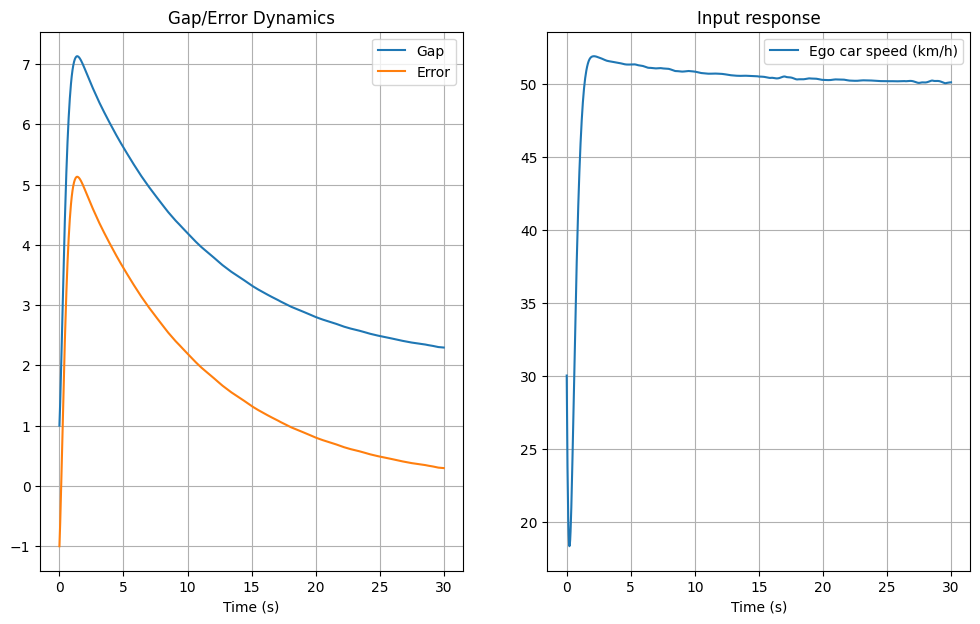

In [16]:
d_ref=2

# System dynamics (A, B matrices)
A = np.array([[0, -1, 0],
              [0,  0, 0],
              [1,  0, 0]])

B = np.array([[0], 
              [1], 
              [0]])

# Cost matrices
Q = np.diag([10, 1, 0.1])  # Penalize gap error, velocity error, and integral error
R = np.array([[0.1]])      # Penalize control effort

# Solve Riccati equation for LQR gain K
K, S, E = lqr(A, B, Q, R) # State feedback gains, Solution to Riccati equation, Eigenvalues of the closed loop system

print("LQR Gain (K):", K)

# Define system with LQR
def System(t: float, x: np.ndarray, v_fwd: float):
    y = x[0]
    e = y - d_ref #error
    i_e = x[2] #add state variable to track integral of error
    v_ego = x[1]
    d_e = v_fwd - v_ego # dot(d)=0, constant reference
    
    #PID:
    u = float(-K @ x) #convert array to single value

    #dynamics:
    d_x1 = v_fwd - x[1] #gap dynamics
    d_x2 = u #ego vehicle acceleration/velocity dynamics
    d_I = e #solver will integrate and we get integral(e) 
    
    return np.array([
        d_x1, #x1
        d_x2, #x2
        d_I # for I part
    ])

t_end = 30
t = np.linspace(0, t_end, 1000)
v_i_0 = 30/3.6 #divided by 3.6 for km/h -> m/s conversion
x_0 = np.array([1, v_i_0, 0]) # initial gap (m), initial ego speed (m/s), initial integral error 
u = 0 #car full stop
v_fwd = 50/3.6 # constant forward vehicle speed for now

x = integrate.solve_ivp(System, (0, t_end), x_0, t_eval=t, args=(v_fwd, )) #uses runge-kutta
d, v_i, I = x.y
y = d
e = y - d_ref
print(e)
plot(x.t, v_i, d, e)

# Constant Time Headway (CTH) Policy

## PID

[-7.83333333e+00 -7.80404586e+00 -7.77458157e+00 -7.74494989e+00
 -7.71515994e+00 -7.68522058e+00 -7.65514038e+00 -7.62492768e+00
 -7.59459054e+00 -7.56413682e+00 -7.53357408e+00 -7.50290971e+00
 -7.47215083e+00 -7.44130437e+00 -7.41037705e+00 -7.37937535e+00
 -7.34830560e+00 -7.31717390e+00 -7.28598618e+00 -7.25474817e+00
 -7.22346545e+00 -7.19214340e+00 -7.16078725e+00 -7.12940206e+00
 -7.09799274e+00 -7.06656403e+00 -7.03512053e+00 -7.00366672e+00
 -6.97220689e+00 -6.94074524e+00 -6.90928581e+00 -6.87783251e+00
 -6.84638915e+00 -6.81495939e+00 -6.78354680e+00 -6.75215480e+00
 -6.72078674e+00 -6.68944583e+00 -6.65813518e+00 -6.62685781e+00
 -6.59561665e+00 -6.56441449e+00 -6.53325408e+00 -6.50213804e+00
 -6.47106893e+00 -6.44004920e+00 -6.40908124e+00 -6.37816733e+00
 -6.34730971e+00 -6.31651051e+00 -6.28577180e+00 -6.25509558e+00
 -6.22448378e+00 -6.19393825e+00 -6.16346080e+00 -6.13305316e+00
 -6.10271698e+00 -6.07245389e+00 -6.04226543e+00 -6.01215309e+00
 -5.98211831e+00 -5.95216

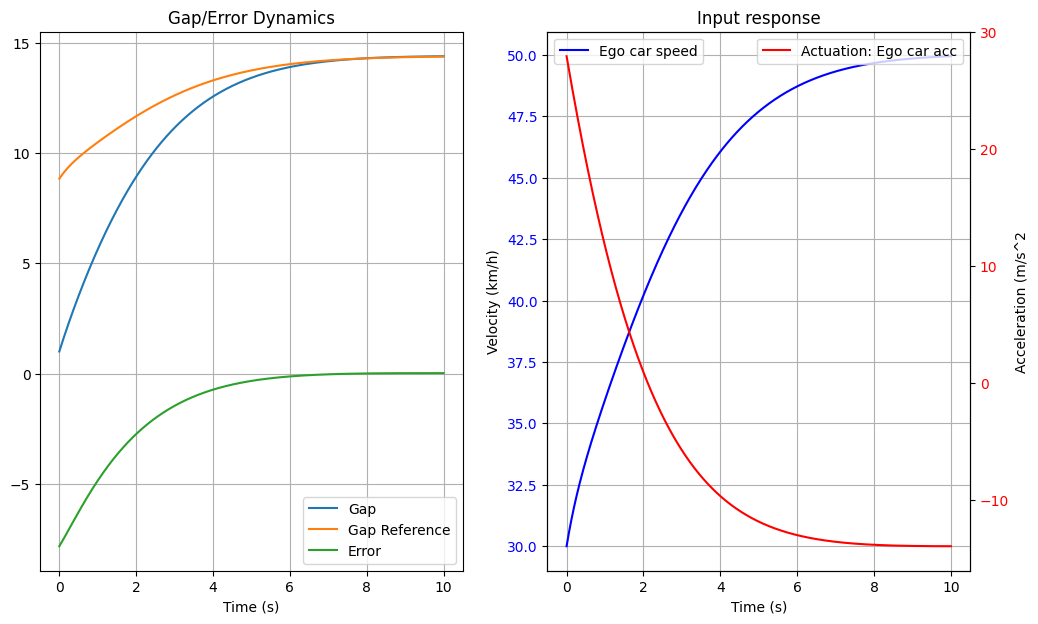

In [35]:
d_min = 0.5 #min gap (emergency)
v_p = 50/3.6 #constant leader speed for now
h = 1 #1s time headway

#PI constants
Kp = 5
Ki = 2
Kd = 3
denom = 1 - Kd * h

#simulation values
t_end = 10
t = np.linspace(0, t_end, 1000)
v_i_0 = 30/3.6 #divided by 3.6 for km/h -> m/s conversion
x_0 = np.array([1, v_i_0, 0]) # initial gap (m), initial ego speed (m/s), initial integral error 


#u1 = d_min
#u2 = v_i-1
u = np.zeros((t.shape[0], 2))
u[:, 0] = d_min # constant min gap
u[:, 1] = v_p 

#closed-loop state space system
A = np.array([
    [0, -1, 0],
    [-Kp/denom, (Kp*h + Kd)/denom, Ki/denom],
    [-1, h, 0]
])

B = np.array([
    [0 , 1],
    [Kp/denom, -Kp/denom],
    [1 , 0]
])

#y = gap = x1
C = np.array([1, 0, 0])
D = np.zeros((1, 2))

sys = signal.StateSpace(A, B, C, D)
t_out, y, x = signal.lsim(sys, u, t, x_0)
d_ref = d_min + h*x[:,1]
e = x[:,0] - d_ref
act = (Kp*e + Ki*x[:,2] + Kd * (x[:,1] - v_p)) / (1 - Kd * h) #recover actuation computed by controller
print(e)
plot(t=t_out, v_i=x[:,1], a_i=act , d=x[:,0], d_ref=d_ref, e=e)


# Real-time

In [44]:
class vehicle:
    def __init__(self, d_min, h, Kp, Ki, Kd, x0: np.array):
        self.d_min = d_min
        self.h = h
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd

        self.x0 = x0

        self.e_t = []
        self.u_t = []
        self.d_t = []
        self.v_t = []
        self.d_ref_t = []
        
    def policy(self, v_i):
        d_ref = self.d_min + self.h*v_i
        return d_ref

    def pid(self, x, d_ref, v_p):
        d, v_i, i_e = x
        
        e = d_ref - d
        denom = 1 - self.Kd * self.h
        if np.abs(denom) < 1e-8:
            raise ValueError("Denom (1 - Kd*h) is zero. Adjust Kd and h.")
        
        u = (self.Kp * e + self.Ki * i_e + self.Kd * (v_i - v_p)) / denom
        
        return e, u

    def plant(self, x, e, u, v_p):
        d, v_i, i_e = x

        #dynamics:
        d_x1 = v_p - v_i #gap dynamics
        d_x2 = u #ego vehicle acceleration/velocity dynamics
        d_I = e #solver will integrate and we get integral(e) 
        
        return np.array([
            d_x1, #x1
            d_x2, #x2
            d_I # aux (error integral)
        ])

    def compute(self, t, x, v_p):
        v_i = x[1]
        d_ref = self.policy(v_i)
        e, u = self.pid(x, d_ref, v_p)
        new_x = self.plant(x, e, u, v_p)
        return new_x

TypeError: can't multiply sequence by non-int of type 'float'

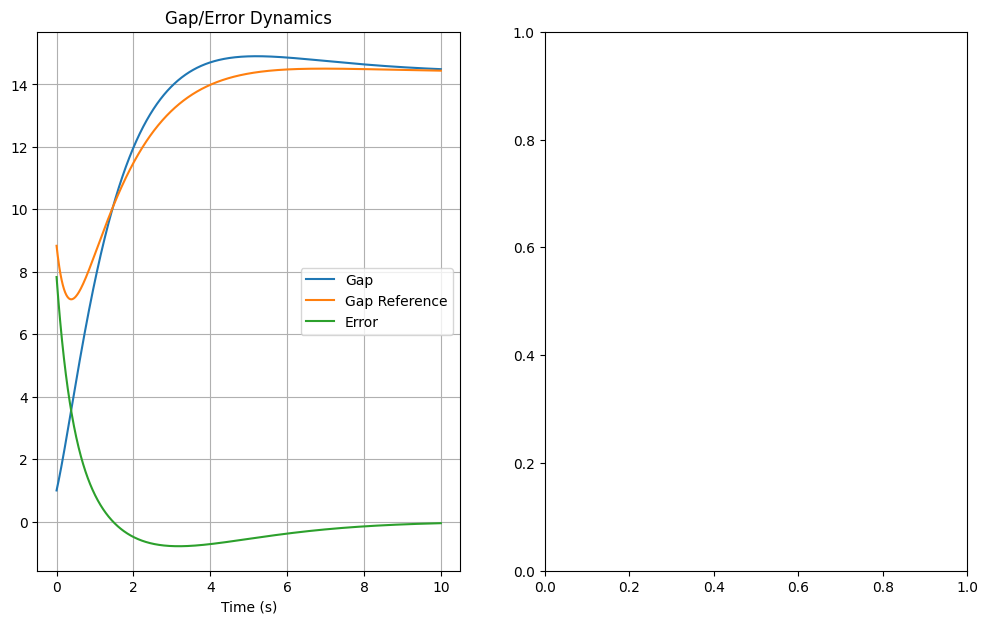

In [ ]:
#----- globals
d_min=0.5
h=1
#PI constants
Kp = 5
Ki = 2
Kd = 3
#----

#simulation values
t_end = 10
lv_speed = np.ones_like(t) * 50/3.6 #constant leader speed
fv0_x0 = np.array([1, 30/3.6, 0])
fv0 = vehicle(d_min, h, Kp, Ki, Kd, fv0_x0) #initial state -> gap, km/h, error integral
#TODO adjust here for variable preceeding speed
rk = integrate.RK45(lambda t, x: fv0.compute(t, x, lv_speed[0]), t0=0, y0=fv0_x0, t_bound=t_end, max_step=0.01)
t = []
while rk.status == 'running':
    x = rk.y
    d, v = x[:2]
    t_curr = rk.t   
    t.append(t_curr)
    fv0.d_t.append(d)
    fv0.v_t.append(v)
    #retrace e, u and d_ref history (sync with solver):
    d_ref = fv0.policy(v)
    fv0.d_ref_t.append(d_ref)
    e, u = fv0.pid(x, d_ref, lv_speed[0]) #TODO: and here 
    fv0.e_t.append(e)
    fv0.u_t.append(u)
    fv0.plant(x, e, u, lv_speed[0]) #TODO: and here 
    
    rk.step()

plot(t, np.array(fv0.v_t), np.array(fv0.u_t), fv0.d_t, fv0.d_ref_t, fv0.e_t)
